# 1. Problèmatique du projet

L'objectif du projet P8 "Déployez un modèle dans le cloud" est:
 - de développer le pre-processing (chargement des données, traitement des images, extraction des features) et une réduction de PCA dans le cadre d'un traitement d'images avec PySpark
 - de déployer ce développement dans un environnement Big Data (S3 - Sagemaker - Spark). 

# 2. Environnement de travail et import des librairies

In [1]:
# Importation des librairies ML standard 
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt
from IPython.display import Image                 
from IPython.display import display
from PIL import Image
from io import StringIO

# Import des librairies AWS: S3, Sagemaker, PySpark
# S3
import boto3
import botocore.session

# Sagemaker
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
import sagemaker_pyspark

# Pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import input_file_name
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import split
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import PCA

# Tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

# Autres librairies
import time
from io import BytesIO

# 3. Fonctions

In [2]:
# Fonction pour l'initialisation de la session spark
def init_spark_session(bucket=''):
    '''Initialise une session SPARK
    Entrée:
    - bucket : nom du bucket S3
      string
    
    Retour:
    - contexte SparkContext
    - chemin d\'acces aux images dans bucket S3
    '''
    
    # Acccès distant aux données sur compartiment AWS S3 depuis notebook Sagemaker
    path_img = "s3a://"+bucket_name+"/**"
        
    session = botocore.session.get_session()
    credentials = session.get_credentials()
        
    conf = (SparkConf()
        .set("spark.driver.extraClassPath", ":".join(sagemaker_pyspark.classpath_jars())))
        
    spark = (
        SparkSession
        .builder
        .config(conf=conf) \
        .config('fs.s3a.access.key', credentials.access_key) \
        .config('fs.s3a.secret.key', credentials.secret_key) \
        .config("spark.driver.memory", "15g") \
        .master('local[*]') \
        .appName('P8_OC_dc') \
        .getOrCreate()
    ) 

    sc = spark.sparkContext
    
    return sc, spark, path_img

In [3]:
# Fonction pour le chargement des données
def load_data(path_img):
    '''Chargement des dataframes: 
    Entrée:
    - path_image: répertoire qui contient les sous répertoires contenant les images
      string
    
    Retour:
    df_img: un spark dataframe contenant les images et le nom des fruits associés
    '''
    # Compteur
    start = time.time()
    
    # Chargement dataframe spark avec les images
    df_img = spark.read.format("image").load(path_img, inferschema=True)
    print('Chargement des images effectué')
    
    df_img = df_img.withColumn("fileName", regexp_replace('image.origin', 'dbfs:/mnt/images/', '')) 
    split_col =split(df_img['fileName'], '/')
    df_img = df_img.withColumn('categorie', split_col.getItem(3))
    
    df_img_disp = df_img.select('image', 'image.origin',"image.height","image.width","image.nChannels", "image.mode", "image.data",'categorie')
    df_img_trait = df_img.select('image.origin',"image.height","image.width","image.nChannels", "image.mode", "image.data",'categorie')
    
    print('Temps de chargement des images : {} secondes'.format(time.strftime('%S', time.gmtime(time.time()-start))))
    
    return df_img_trait, df_img_disp

In [4]:
# Fonction qui donne des informations sur un dataframe spark
def spark_shape(dfs):
    '''Renvoie des informations sur un dataframe spark: 
    Entrée:
    - dfs: dataframe spark
    
    Retour:
    - nombre enregistrements
      int
    - nombre de colonnes
      int
    '''
    return (dfs.count(), len(dfs.columns))

In [5]:
# Fonction pour déterminer la catégorie de l'image
def parse_categorie(path):
    '''Renvoie la catégorie d\'une image à partir de son chemin
    Entrée:
    - chemin complet de l\'image
      string
    Retour:
    - catégorie de l\'image
      string
    '''
    if len(path) > 0:
        # Catégorie de l'image
        return path.split('/')[-2]
    else:
        return ''

In [6]:
# Fonction pour l'affichage d'un image
def display_image(dfs, categorie):
    '''Renvoie un image de la catégorie d\'image
    Entrée:
    - dataframe spark
    - catégorie image
      string
    Retour:
    - tableau représentant l\'image
      array
    '''
    filter_cat = dfs.filter(dfs.categorie == categorie)
    list_height = filter_cat.select('height').collect()
    list_width = filter_cat.select('width').collect()
    height = list_height[0].height
    width = list_width[0].width

    image_1 = filter_cat.first()

    aff_img = np.array(image_1.asDict()['image']['data']).reshape(height,width,3)[:,:,::-1]
    
    return aff_img

In [7]:
# Fonction pour l'extraction des features sur VGG16
def extract_features_vgg16(bucket_name):
    '''Renvoie l\extraction des features à partir de VGG16
    Entrée:
    - nom du bucket S3
    
    Retour:
    - features de l\'image
    '''
    # Compteur
    start = time.time()
    
    model = VGG16(include_top=False, weights='imagenet', pooling='max',input_shape=(224, 224, 3))
    model.summary()
    
    # Récupération des ressources sur le service AWS S3
    s3_client = boto3.client("s3")
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    
    vgg16_features=[]
    
    for my_bucket_object in bucket.objects.all():
        if my_bucket_object.key.endswith('jpg'):
            file_byte_string = s3_client.get_object(Bucket=bucket_name, Key=my_bucket_object.key)['Body'].read()
            
            # Chargement de l'image
            img = Image.open(BytesIO(file_byte_string))
            
            # Redimensionnement de l'image en 224*224 pixels
            img_redim = img.resize((224, 224))
            
            # Conversion de l'image en array
            img_array = image.img_to_array(img_redim).reshape((-1,224,224,3))
            img_array = np.array(img_array)
            
            # Pre-processing des images
            img_array = preprocess_input(img_array)
            
            # Extraction de features pour un image
            feature = model.predict(img_array).ravel().tolist()
            
            vgg16_features.append(feature)
            
    print('Temps de chargement extraction features : {} secondes'.format(time.strftime('%S', time.gmtime(time.time()-start))))
    return vgg16_features

In [8]:
# Fonction pour ajout features dans dataframe pyspark
def features_pyspark_df(features, df_img):
    '''Ajoute les features à une dataframe pyspark
    Entrée:
    - features de l\'image
    - dataframe pyspark
    
    Retour:
    - dataframe pyspark avec les informations sur les images et les features
    '''
    features_df = spark.createDataFrame([(l,) for l in features], ['features'])
    
    df_img = df_img.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
    features_df = features_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

    df_img_feat = df_img.join(features_df, df_img.row_idx == features_df.row_idx).drop("row_idx")
    return df_img_feat

In [9]:
# Fonction pour réduction de dimensions PCA
def reduc_dim_pca(features):
    '''Réduction des dimensions PCA sur les feature
    Entrée:
    - features de l\'image
    
    Retour:
    - pca
    - pca_matrix: résultat de la réduction de dimensions
    '''
    # Conversion d'un tableau (array) en vecteur dense
    # Création d'un fonction utilisateur avec udf
    vector_dense = udf(lambda x: Vectors.dense(x), VectorUDT())
    img_vd_df = features.select('origin', 'categorie','features', vector_dense("features").alias("features_vd"))
    
    # PCA
    pca_spark = PCA(inputCol="features_vd", outputCol="features_pca", k=100)
    pca = pca_spark.fit(img_vd_df)
    pca_matrix = pca.transform(img_vd_df)
    
    return pca, pca_matrix

In [10]:
# Fonction pour l'affichage du diagramme des éboulis PCA
def display_pca_eboulis(pca):
    '''Affichage du diagramme des éboulis sur PCA
    Entrée:
    - pca
    
    Retour:
    - N/A
    '''
    # Variance expliquée
    varexpl = pca.explainedVariance*100
        
    # Affichage de la variance cumulée
    plt.figure(figsize=(11,7))
    plt.bar(np.arange(len(varexpl))+1, varexpl)

    cumSumVar = varexpl.cumsum()
    plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
    plt.axhline(y=90, linestyle="--", 
                color="green",
                linewidth=1)

    limit = 90
    valid_idx = np.where(cumSumVar >= limit)[0]
    min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
    plt.axvline(x=min_plans, linestyle="--", 
                color="green",
                linewidth=1)

    plt.xlabel("Rang de l'axe d'inertie pour les composantes K")
    plt.xticks(np.arange(0,105,5))
    plt.xlim(left=0)
    plt.ylabel("Pourcentage d'inertie")
    plt.title("{}% de la variance totale est expliquée"\
                " par les {} premiers axes".format(limit,
                                            min_plans))
    plt.show(block=False)
        
    return None

In [11]:
# Fonction pour la sauvegarde d'un fichier csv sur un bucket s3
def save_csv_bucket_s3(pca_matrix, file_name, bucket_name):
    '''Sauvegarde résultats dans bucket S3 sous forme d'un fichier csv
    Entrée:
    - pca_matrix
      dataframe pyspark
    - nom du fichier crsv à sauvegarder
      string
    - bucket_name: nom du bucket_s3  
    
    Retour:
    - N/A
    '''
    s3_resource = boto3.resource('s3')
    
    # Création d'un buffer 
    csv_buffer = StringIO()
    
    # Transformation dans un structure dataframe pandas
    pca_matrix.toPandas().to_csv(csv_buffer)
    
    # Ecriture du fichier csv dans le bucket s3
    s3_resource.Object(bucket_name, file_name).put(Body=csv_buffer.getvalue())
    

# 4. Traitement des images

Définition du nom de bucket pour la lecture des images.

In [12]:
# Paramètres de l'application
bucket_name = 'p8-mldl-s3-bucket'

## 4.1 Initialisation d'une session Spark

Création de l'environnement d'exécution Spark:
- accès aux jar
- visibilité sur les clés d'identification du compte AWS
- ajustement des paramètres pour la gestion de la mémoire Java (Java Heap size)

In [13]:
# Initialisation d'une session Spark
sc, spark, path = init_spark_session(bucket=bucket_name)

In [14]:
# Affichage du contexte pyspark
sc

<SparkContext master=local[*] appName=P8_OC_dc>

## 4.2 Chargement des images à partir d'un compartiment AWS S3

Lecture des images dans la bucket S3 "'p8-mldl-s3-bucket":
- chargement des images
- création d'un colonne "categorie"
- affichage des caractéristiques des images (hauteur, largeur, nombre de canaux)

In [15]:
# Chargement du dataframe contenant les images, leur chemin et leur catégorie
images_trait, images_display = load_data(path)

Chargement des images effectué
Temps de chargement des images : 03 secondes


In [16]:
# Affichage des 20 premières images
images_trait.show(20)

+--------------------+------+-----+---------+----+--------------------+----------+
|              origin|height|width|nChannels|mode|                data| categorie|
+--------------------+------+-----+---------+----+--------------------+----------+
|s3a://p8-mldl-s3-...|   435|  540|        3|  16|[FF FF FF FF FF F...|    pear_1|
|s3a://p8-mldl-s3-...|   434|  532|        3|  16|[FF FF FF FF FF F...|    pear_1|
|s3a://p8-mldl-s3-...|   526|  421|        3|  16|[FF FF FF FF FF F...|    pear_1|
|s3a://p8-mldl-s3-...|   527|  411|        3|  16|[FF FF FF FF FF F...|    pear_1|
|s3a://p8-mldl-s3-...|   435|  538|        3|  16|[FF FF FF FF FF F...|    pear_1|
|s3a://p8-mldl-s3-...|   527|  421|        3|  16|[FF FF FF FF FF F...|    pear_1|
|s3a://p8-mldl-s3-...|   434|  538|        3|  16|[FF FF FF FF FF F...|    pear_1|
|s3a://p8-mldl-s3-...|   435|  537|        3|  16|[FF FF FF FF FF F...|    pear_1|
|s3a://p8-mldl-s3-...|   527|  417|        3|  16|[FF FF FF FF FF F...|    pear_1|
|s3a

In [17]:
# Taille de la dataframe pyspark
spark_shape(images_trait)

(1007, 7)

In [18]:
# Affichage des différentes catégories d'image
images_by_categ_df = images_trait.groupBy("categorie").count()
images_by_categ_df.show()

+--------------------+-----+
|           categorie|count|
+--------------------+-----+
|apple_granny_smith_1|  320|
|          cucumber_1|  100|
|            carrot_1|  101|
|              pear_1|  326|
|          zucchini_1|  160|
+--------------------+-----+



## 4.3 Images d'origine

### 4.3.1 Affichage image origine - Catégorie "cucumber_1"

(798, 323, 3)


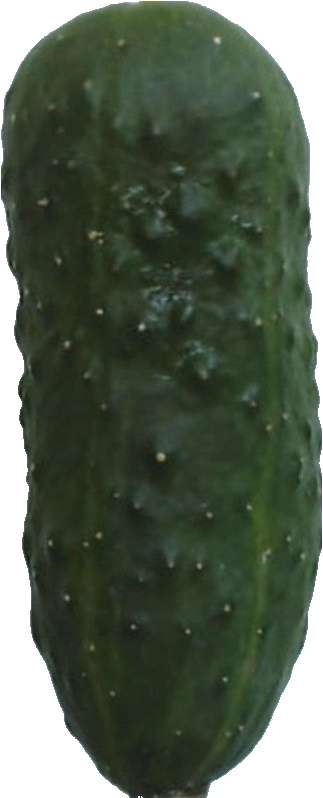

In [19]:
image_cat = display_image(images_display, "cucumber_1")
print(image_cat.shape)
Image.fromarray(image_cat, 'RGB')

### 4.3.2 Affichage image origine - Catégorie "apple_granny_smith_1"

(454, 478, 3)


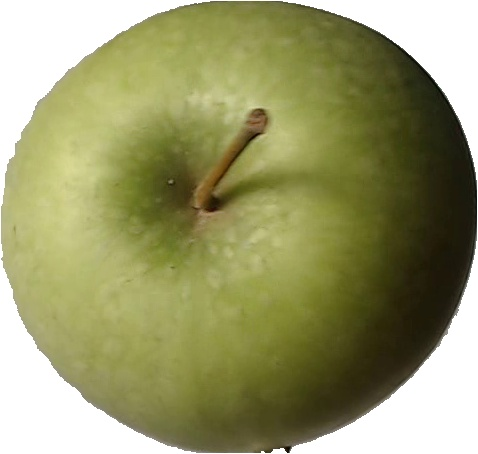

In [20]:
image_cat = display_image(images_display, "apple_granny_smith_1")
print(image_cat.shape)
Image.fromarray(image_cat, 'RGB')

### 4.3.3 Affichage image origine - Catégorie "carrot_1"

(643, 216, 3)


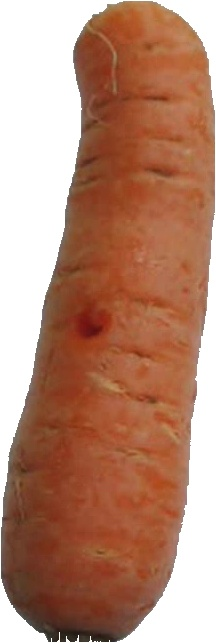

In [21]:
image_cat = display_image(images_display, "carrot_1")
print(image_cat.shape)
Image.fromarray(image_cat, 'RGB')

### 4.3.4 Affichage image origine - Catégorie "pear_1"

(435, 540, 3)


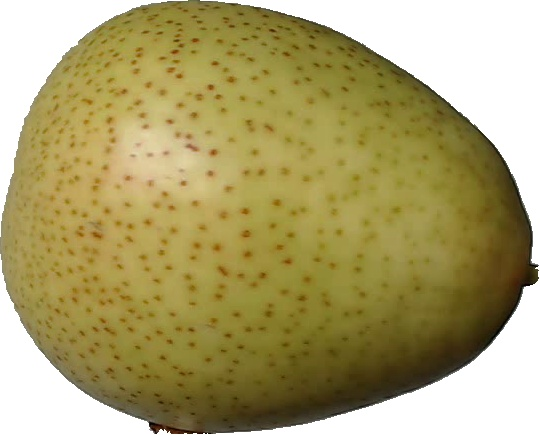

In [22]:
image_cat = display_image(images_display, "pear_1")
print(image_cat.shape)
Image.fromarray(image_cat, 'RGB')

### 4.3.5 Affichage image origine - Catégorie "zucchini_1"

(1031, 289, 3)


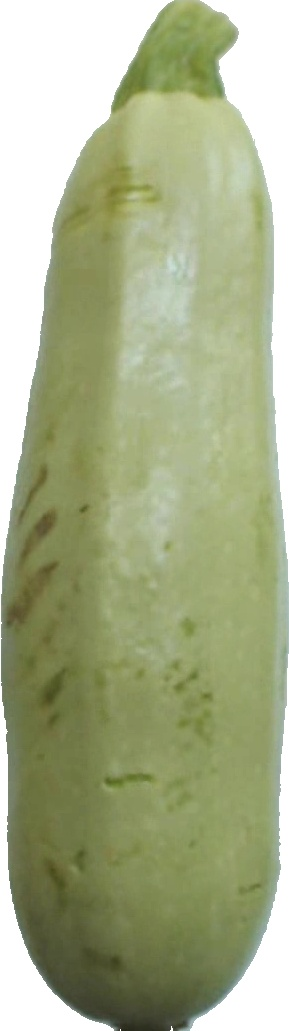

In [23]:
image_cat = display_image(images_display, "zucchini_1")
print(image_cat.shape)
Image.fromarray(image_cat, 'RGB')

## 4.4 Extraction des features par VGG16

Extraction des features via un modèle pré-entrainé VGG16 à partir d'une base d'images Imagenet.

Ajout de features dans une dataframe Spark.

In [24]:
# Extraction des features
image_features = extract_features_vgg16(bucket_name)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
# Ajout features à la dataframe pyspark
images_feat_df = features_pyspark_df(image_features, images_trait)

In [26]:
images_feat_df.show(20)

+--------------------+------+-----+---------+----+--------------------+----------+--------------------+
|              origin|height|width|nChannels|mode|                data| categorie|            features|
+--------------------+------+-----+---------+----+--------------------+----------+--------------------+
|s3a://p8-mldl-s3-...|   435|  540|        3|  16|[FF FF FF FF FF F...|    pear_1|[60.2613334655761...|
|s3a://p8-mldl-s3-...|   434|  532|        3|  16|[FF FF FF FF FF F...|    pear_1|[70.5976409912109...|
|s3a://p8-mldl-s3-...|   526|  421|        3|  16|[FF FF FF FF FF F...|    pear_1|[56.7357063293457...|
|s3a://p8-mldl-s3-...|   527|  411|        3|  16|[FF FF FF FF FF F...|    pear_1|[56.5463790893554...|
|s3a://p8-mldl-s3-...|   435|  538|        3|  16|[FF FF FF FF FF F...|    pear_1|[56.8080062866210...|
|s3a://p8-mldl-s3-...|   527|  421|        3|  16|[FF FF FF FF FF F...|    pear_1|[59.5471496582031...|
|s3a://p8-mldl-s3-...|   434|  538|        3|  16|[FF FF FF FF F

In [27]:
# Affichage des différentes catégories d'image
images_by_categ_df_feat = images_feat_df.groupBy("categorie").count()
images_by_categ_df_feat.show()

+--------------------+-----+
|           categorie|count|
+--------------------+-----+
|              pear_1|  326|
|          cucumber_1|  100|
|          zucchini_1|  160|
|apple_granny_smith_1|  320|
|            carrot_1|  101|
+--------------------+-----+



# 5. Réduction de dimensions PCA avec la librairie SparkMLib

Réduction de dimensions PCA à partir des features, en prenant en compte 100 composantes principales en entrée (K).

Intégration des vecteurs denses produits à partir des features et de la sortie de la reduction PCA dans une dataframe Spark.

In [28]:
# Fonction pour la réduction de dimension PCA
pca, pca_matrix = reduc_dim_pca(images_feat_df)

In [29]:
pca_matrix.show(20)

+--------------------+----------+--------------------+--------------------+--------------------+
|              origin| categorie|            features|         features_vd|        features_pca|
+--------------------+----------+--------------------+--------------------+--------------------+
|s3a://p8-mldl-s3-...|    pear_1|[60.2613334655761...|[60.2613334655761...|[244.967693724988...|
|s3a://p8-mldl-s3-...|    pear_1|[70.5976409912109...|[70.5976409912109...|[237.879241083890...|
|s3a://p8-mldl-s3-...|    pear_1|[56.7357063293457...|[56.7357063293457...|[310.678845815459...|
|s3a://p8-mldl-s3-...|    pear_1|[56.5463790893554...|[56.5463790893554...|[314.179557151492...|
|s3a://p8-mldl-s3-...|    pear_1|[56.8080062866210...|[56.8080062866210...|[312.563467567600...|
|s3a://p8-mldl-s3-...|    pear_1|[59.5471496582031...|[59.5471496582031...|[316.151559872676...|
|s3a://p8-mldl-s3-...|    pear_1|[46.6975746154785...|[46.6975746154785...|[298.142309540999...|
|s3a://p8-mldl-s3-...|    pear

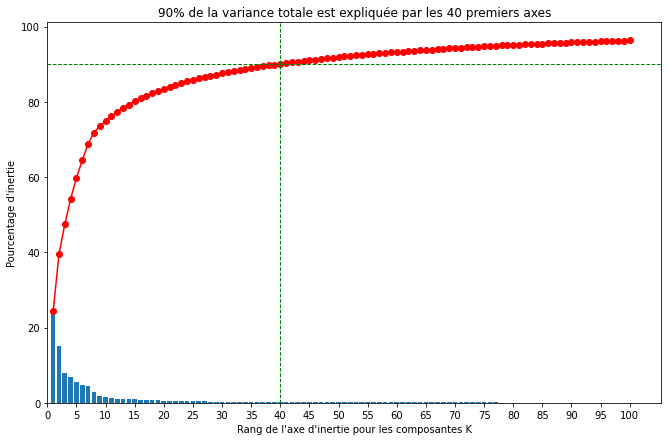

In [30]:
# Affichage du diagramme des éboulis
display_pca_eboulis(pca)

Le diagramme des éboulis montre que l'on obient 90 % de la variance expliquée totale avec 40 composantes principales, soit 20 plans factoriels.

On peut en déduire qu'il est possible de faire une compression des images dans un facteur 2,5 par rapport à leut taille d'origine, sans perdre trop d'informations.

# 6. Sauvegarde résultats du traitement dans un bucket S3

Sauvegarde des résultats dans un bucket S3:
- création d'un nouveau bucket S3 (p8-mldl-s3-bucket-matrix)
- transformation de la dataframe Spark des résultats en dataframe Pandas et enregistrement au format csv
- enregistrement du fichier csv sur le bucket S3

In [31]:
bucket_name_matrix = 'p8-mldl-s3-bucket-matrix'
save_csv_bucket_s3(pca_matrix, 'p8_result_with_pca.csv', bucket_name_matrix)

# 7. Arrêt de la session Spark

Arrêt de la session Spark pour permettre la libération des ressources (mémoire Java, processeur,...).

In [32]:
# Arrêt de la session Spark
spark.stop()